In [1]:
import os
import pandas as pd, numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 경로 정의하기
dataPath = os.path.join(os.getcwd(), '..\\..\\Dataset')

# 칵테일 프로필 데이터 불러오기
merged_cocktail_df = pd.read_json(os.path.join(dataPath, 'merged_cocktail_list_new.json'))
unmerged_cocktail_df = pd.read_json(os.path.join(dataPath, 'Cocktail_profile_dataset_translated.json'))
cocktail_df = pd.read_json(os.path.join(dataPath, 'cocktail_list.json'))

In [6]:
cocktail_id_mapping_dict = {}
name_to_id_dict = {}
merge_mapper = {}

merged_cocktail_df[['Name', 'ID']]
unmerged_cocktail_df[['Name', 'ID']]

# 칵테일 ID 매핑 딕셔너리 생성
for i in range(len(unmerged_cocktail_df)):
    cocktail_id_mapping_dict[unmerged_cocktail_df['ID'][i]] = unmerged_cocktail_df['Name'][i]

print(len(cocktail_id_mapping_dict), cocktail_id_mapping_dict)

cocktail_name_list = merged_cocktail_df['Name'].to_list()

for name in cocktail_name_list:
    if name not in cocktail_id_mapping_dict.values():
        print(name)  # 빠진 칵테일 이름 없음!

for i in range(len(merged_cocktail_df)):
    name_to_id_dict[merged_cocktail_df['Name'][i]] = merged_cocktail_df['ID'][i]

print(len(name_to_id_dict), name_to_id_dict)

# 칵테일 ID 매핑하기
for id, name in cocktail_id_mapping_dict.items():
    original_id = id
    new_id = name_to_id_dict[name] if name in name_to_id_dict else None
    if new_id is None: continue
    #print(original_id, name, new_id)
    merge_mapper[original_id] = new_id

print(merge_mapper)


174 {10020: 'Absinthe Margarita', 10297: 'Absinthe Sour', 10159: 'Alexander', 10136: 'Alexander', 10391: 'Alexander', 10657: 'Alexander', 10303: 'Amaretto Sour', 10183: 'Americano', 10103: 'Angel Blue', 10815: 'Aperol Fizz', 10583: 'Aperol Lillet', 10756: 'Aperol Sour', 10090: 'Apple Juice Soda Gin', 10272: 'Apricot Sunset', 10644: 'B-52', 10393: 'B-52', 10661: 'Bacardi', 10552: 'Bahama Mama', 25: 'Bahama Mama', 10720: 'Bellini', 10412: 'Between The Sheets', 10822: 'Black Russian', 10336: 'Blackberry Mojito', 31: 'Bloody Mary', 10286: 'Bloody Mary', 44: 'Blue Hawaiian', 10498: 'Blue Hawaiian', 10726: 'Blue Lagoon', 10372: 'Blue Lagoon', 21: 'Blue Motorcycle', 57: 'Blueberry Tea Cocktail', 10562: 'Caipirinha', 10696: 'Caipirinha Strawberry', 10252: 'Campari Fizz', 10274: 'Campari Orange', 10645: 'Campari Vodka Cocktail', 13: 'Cape Cod', 43: 'Cape Cod', 10405: 'Captain Cola', 10551: 'Caribbean Cocktail', 10247: 'Casanova', 10537: 'Coco Loco', 10245: 'Coco Loco', 6: 'Cosmopolitan', 10040:

In [7]:
# 칵테일 리뷰 데이터 불러오기
all_recipe_reviews_df = pd.read_json(os.path.join(dataPath, 'all_recipe_cocktail_reviews.json'))['cocktail_reviews'].to_list()
gutekueche_reviews_df = pd.read_json(os.path.join(dataPath, 'gutekueche_cocktail_reviews.json'))

all_recipe_reviews_df = pd.DataFrame(all_recipe_reviews_df)

In [8]:
# gutekueche_reviews_df 컬럼명 변경
gutekueche_reviews_df['Date'] = gutekueche_reviews_df['Timestamp']
gutekueche_reviews_df.drop(columns=['Timestamp'], inplace=True)
gutekueche_reviews_df

,Cocktail,User,Review,Date
0,1,Maarja,Sauermilch ist ja gar nicht so leicht zu bekom...,am 07.11.2022 um 19:08 Uhr
1,1,Katerchen,"Die Sauermilch lasse ich weg, nehme Joghurt st...",am 06.02.2022 um 11:41 Uhr
2,1,alpenkoch,Der frische Erdbeer-Sauermilchcocktail sieht a...,am 09.03.2021 um 13:22 Uhr
3,1,snakeeleven,Mit den letzten Erbeeren werde ich heute diese...,am 12.07.2019 um 09:52 Uhr
4,1,Silviatempelmayr,"Statt der sauermilch nehme ich Buttermilch, de...",am 13.07.2018 um 22:08 Uhr
...,...,...,...,...
2163,828,xblue,Der Absinth Maracuja Cocktail am Foto ist ein ...,am 08.02.2021 um 14:24 Uhr
2164,828,Heinrich45,Ganz böses Getränk. Trinkt sich wie eine Apfel...,am 08.01.2020 um 19:44 Uhr
2165,829,snakeeleven,"Cassandra das ist eine gute Idee von Dir, aber...",am 29.11.2019 um 13:54 Uhr
2166,829,Maisi,Durch die Farbe von Fanta und wahrscheinlich a...,am 25.04.2019 um 07:57 Uhr


In [9]:
# 각 데이터셋 날짜 포맷 변경 YYYY-MM-DD
all_recipe_reviews_df['Date'] = pd.to_datetime(all_recipe_reviews_df['Date']).dt.strftime('%Y-%m-%d')

gutekueche_reviews_df['Date'] = gutekueche_reviews_df['Date'].apply(lambda x: x.split(' ')[1])\
                                     .apply(lambda x: x.split('.'))\
                                     .apply(lambda y: y[2] + '-' + y[1] + '-' + y[0])


In [10]:
# gutekueche cocktail의 Cocktail = Cocktail + 10000
gutekueche_reviews_df['Cocktail'] = gutekueche_reviews_df['Cocktail'].apply(lambda x: x + 10000)

In [11]:
# 리뷰 데이터 합치기
cocktail_reviews = pd.concat([all_recipe_reviews_df[['Cocktail', 'User', 'Date', 'Review']],
                               gutekueche_reviews_df[['Cocktail', 'User', 'Date', 'Review']]], ignore_index=True)

cocktail_reviews

,Cocktail,User,Date,Review
0,1,Madaline Rose,2020-11-25,this punch tastes good! i recommend it! there’...
1,1,Wayne Wess,2020-08-17,Pretty good. Added some pimento for more flavor
2,1,JEM,2020-05-28,Reminds me of a cousin to the Mai Tai. I also ...
3,1,Jason Santiago,2020-03-20,Added a pinch more of grenadine other than tha...
4,1,Andrea Judd,2019-06-01,Yumo! Made exactly except subbed regular Bacar...
...,...,...,...,...
7858,10828,xblue,2021-02-08,Der Absinth Maracuja Cocktail am Foto ist ein ...
7859,10828,Heinrich45,2020-01-08,Ganz böses Getränk. Trinkt sich wie eine Apfel...
7860,10829,snakeeleven,2019-11-29,"Cassandra das ist eine gute Idee von Dir, aber..."
7861,10829,Maisi,2019-04-25,Durch die Farbe von Fanta und wahrscheinlich a...


In [12]:
# 칵테일 매핑하기 (없으면 제거)
cocktail_reviews['Cocktail'] = cocktail_reviews['Cocktail'].apply(lambda x: merge_mapper[x] if x in merge_mapper else None)

# 칵테일 리뷰 데이터셋에서 칵테일이 없는 리뷰 제거
cocktail_reviews = cocktail_reviews[~cocktail_reviews['Cocktail'].isnull()]

cocktail_reviews

,Cocktail,User,Date,Review
14,2.0,Ann G,2022-10-10,Made this for a party and so many asked about ...
15,2.0,debeca,2020-07-05,"Great as is - it's tropical, fruity, and refre..."
16,2.0,GarbageCan,2018-12-22,Added southern comfort as well which helped an...
17,2.0,Justyna Gebela,2018-05-12,I used champagne instead of a sparkling bevera...
18,2.0,Trish,2018-05-03,Absolutely delicious! Everyone (even people wh...
...,...,...,...,...
7842,10822.0,Heinrich45,2019-12-24,Supereinfach zu machen und schmeckt immer wied...
7843,10822.0,DIELiz,2018-04-17,mal ein Cocktail für den nicht drei bis sieben...
7844,10822.0,Silviatempelmayr,2016-12-11,Oh jetzt bin ich beo den Cocktails gelandet. I...
7845,10187.0,snakeeleven,2019-08-19,"Der Zombie hat's in sich, Rum ,, Bacard) und C..."


In [13]:
# Cocktail의 타입을 int로 변경
cocktail_reviews['Cocktail'] = cocktail_reviews['Cocktail'].astype(int)
# index 제거
cocktail_reviews.reset_index(drop=True, inplace=True)

In [14]:
# 칵테일 리뷰 데이터셋 저장
cocktail_reviews.to_json(os.path.join(dataPath, 'PRADA_cocktail_reviews.json'), orient='records', indent=4)

## 데이터 확인

In [15]:
# 리뷰 달린 총 칵테일 수
print('Total number of cocktails with reviews: ', len(cocktail_reviews['Cocktail'].unique())) # 92개

# 리뷰 달린 총 유저 수
print('Total number of users who left reviews: ', len(cocktail_reviews['User'].unique())) # 4,269명

# 총 리뷰 수
print('Total number of reviews: ', len(cocktail_reviews)) # 5,594개

Total number of cocktails with reviews:  92
Total number of users who left reviews:  4269
Total number of reviews:  5594


In [16]:
# N개 이상 리뷰를 남긴 유저 수
num_reviews = range(1, 10)

for n in num_reviews:
    print('Number of users who left more than {} reviews: {}'.format(n, len(cocktail_reviews.groupby('User').filter(lambda x: len(x) >= n)['User'].unique())))
    

Number of users who left more than 1 reviews: 4269
Number of users who left more than 2 reviews: 340
Number of users who left more than 3 reviews: 134
Number of users who left more than 4 reviews: 86
Number of users who left more than 5 reviews: 57
Number of users who left more than 6 reviews: 44
Number of users who left more than 7 reviews: 35
Number of users who left more than 8 reviews: 30
Number of users who left more than 9 reviews: 26


In [17]:
start = 1
end = 30
step = 5

results = []

num_reviews = [(1, 5), (6, 10), (11, 30)]
# n_review_users 통계
for num_review in num_reviews:
    n_review_users = cocktail_reviews.groupby('User').filter(lambda x: num_review[1] >= len(x) >= num_review[0])['User'].unique()
    n_review_users_reviews = cocktail_reviews[cocktail_reviews['User'].isin(n_review_users)]
    result = n_review_users_reviews.groupby('Cocktail').count()['User'].sort_values(ascending=False)
    print('Number of reviews left by users who left {} <= reviews <= {} : {}'.format(num_review[0], num_review[1], result.sum()))
    print(result.head(), "\n")
    results.append(result.head())

n_review_users = cocktail_reviews.groupby('User').filter(lambda x: len(x) >= num_review[1]+1)['User'].unique()
n_review_users_reviews = cocktail_reviews[cocktail_reviews['User'].isin(n_review_users)]
result = n_review_users_reviews.groupby('Cocktail').count()['User'].sort_values(ascending=False)
print('Number of reviews left by users who left {} <= reviews : {}'.format(num_review[1]+1, result.sum()))
print(result.head())
results.append(result.head())


Number of reviews left by users who left 1 <= reviews <= 5 : 4666
Cocktail
28       1949
10501     601
10754     507
59        288
58        212
Name: User, dtype: int64 

Number of reviews left by users who left 6 <= reviews <= 10 : 150
Cocktail
28       28
10501     9
59        7
10754     7
10496     7
Name: User, dtype: int64 

Number of reviews left by users who left 11 <= reviews <= 30 : 288
Cocktail
10496    20
10501    16
10274    13
10053    12
10514    11
Name: User, dtype: int64 

Number of reviews left by users who left 31 <= reviews : 490
Cocktail
28       70
10754    34
10501    22
58       20
10550    14
Name: User, dtype: int64


In [18]:
import random

4


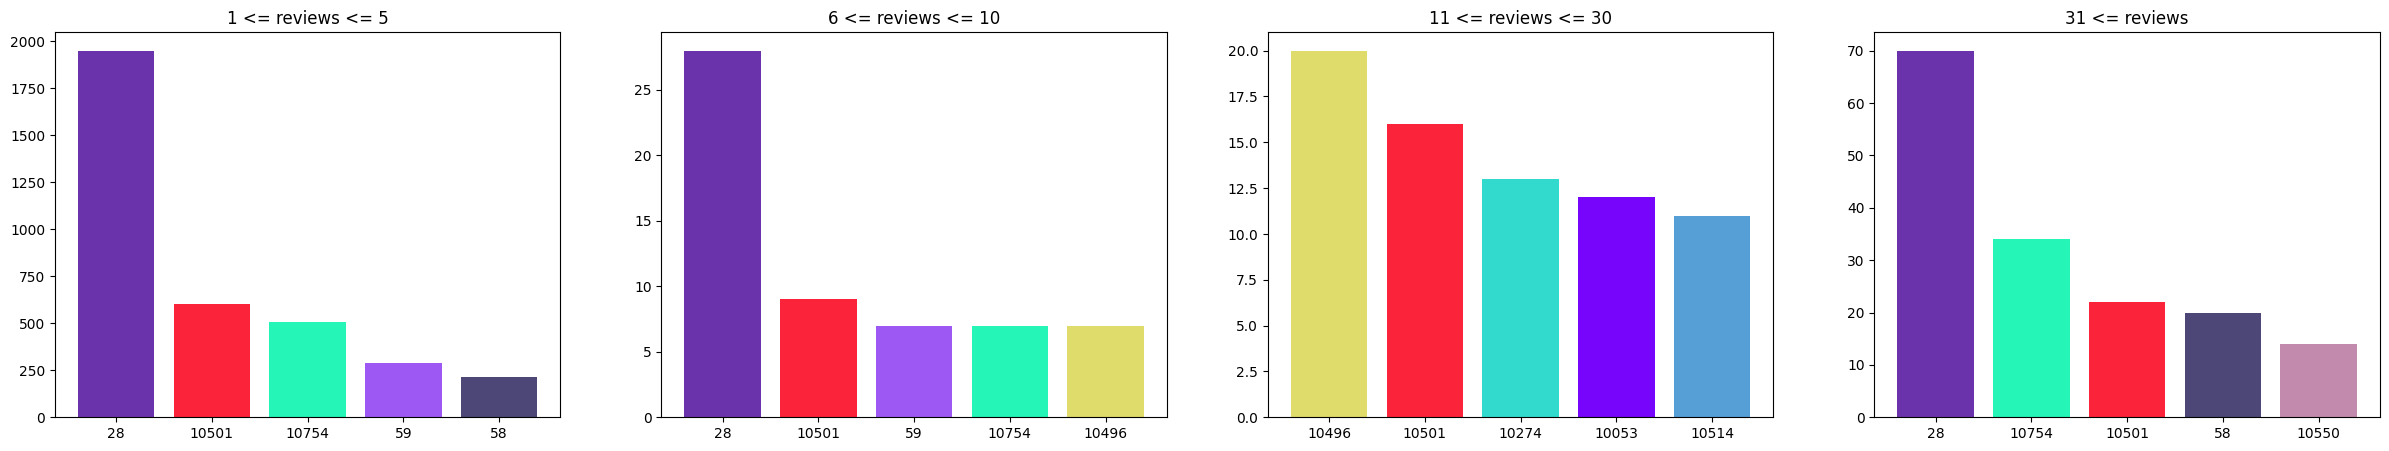

In [23]:
print(len(results))

# 해시 컬러 딕셔너리
hash_color_dict = {}

# 각 result를 pie chart로 그리기
for result in results:
    # result.index별로 컬러 해시 만들기
    for i in result.index:
        if i not in hash_color_dict:
            hash_color_dict[i] = random.randint(0, 0xffffff)


# 한 줄로 그리기
plt.figure(figsize=(30, 5))
for i, result in enumerate(results):
    plt.subplot(1, len(results), i+1)
    plt.bar([str(x) for x in result.index], result.values, color=[f'#{hash_color_dict[i]:06x}' for i in result.index])
    if i != len(num_reviews):
        plt.title(f'{num_reviews[i][0]} <= reviews <= {num_reviews[i][1]}')
    else:
        plt.title(f'{num_reviews[i-1][1]+1} <= reviews')

# 

## 데이터 분석하기

In [20]:
# User - Cocktail 딕셔너리 만들기
user_cocktail_dict = {}

for user in cocktail_reviews['User'].unique():
    user_cocktail_dict[user] = cocktail_reviews[cocktail_reviews['User'] == user]['Cocktail'].unique()

user_cocktail_dict

{'Ann G': array([2]),
 'debeca': array([2]),
 'GarbageCan': array([2]),
 'Justyna Gebela': array([2]),
 'Trish': array([    2,    28, 10286, 10498]),
 'Lisa Edgmond-Wolfe': array([2]),
 'Cassandra': array([2]),
 'Marnie Zorn': array([    2,    28, 10501]),
 'Angela': array([    2,    28, 10501, 10498]),
 'Ellijayjoanne': array([2]),
 'Annette Adams': array([2]),
 'MAD0827': array([2]),
 'Momof4': array([2]),
 'Esmeralda': array([2]),
 'DaniM770': array([2]),
 's johnson': array([2]),
 'kpizzle79': array([2]),
 'suzyq': array([2]),
 'Jennifer Storemski': array([2]),
 'Aimee Carpenter': array([2]),
 'Stephanie Williams': array([2]),
 'blackvelvet49': array([2]),
 'kc1342': array([2]),
 'Amanda Johnson': array([2]),
 'Jillian': array([ 2, 12, 13, 55]),
 'Falguni Dalal': array([2]),
 'wheeler': array([2]),
 'M Lopez': array([2]),
 'Laure T.': array([2]),
 'Clubin': array([2]),
 'Lauren': array([ 2, 28]),
 'MISSSUSIE': array([2]),
 'Katie': array([    2, 10754,    28, 10501,    59]),
 'Asli

In [25]:
# apriori 알고리즘 import
from mlxtend.preprocessing import TransactionEncoder

In [32]:
# Association Rule Mining

# User - Cocktail 딕셔너리를 Transaction 형태로 변환
transactions = []
for user in user_cocktail_dict:
    transactions.append(list(user_cocktail_dict[user]))

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transactions = pd.DataFrame(te_ary, columns=te.columns_)
transactions


,2,9,12,13,20,21,28,41,50,55,...,10726,10731,10747,10754,10756,10788,10793,10798,10816,10822
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4265,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4266,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4267,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
result = apriori(transactions, min_support=0.01, use_colnames=True)

# 결과 정렬
result.sort_values(by='support', ascending=False, inplace=True)

result

,support,itemsets
2,0.443664,(28)
10,0.144999,(10501)
14,0.121340,(10754)
5,0.069103,(59)
4,0.050597,(58)
12,0.032560,(10552)
3,0.030452,(55)
11,0.024362,(10514)
13,0.022488,(10619)
6,0.021785,(10017)


In [48]:
# user_cocktail_dict에서 user가 1개인 경우 제거
user_cocktail_dict = {k: list(v) for k, v in user_cocktail_dict.items() if len(v) > 1}

user_cocktail_dict

{'Trish': [2, 28, 10286, 10498],
 'Marnie Zorn': [2, 28, 10501],
 'Angela': [2, 28, 10501, 10498],
 'Jillian': [2, 12, 13, 55],
 'Lauren': [2, 28],
 'Katie': [2, 10754, 28, 10501, 59],
 'Nicole': [2, 28, 10501],
 'Allrecipes Member': [2,
  10754,
  28,
  12,
  13,
  10359,
  21,
  10552,
  10514,
  10501,
  10051,
  10017,
  41,
  10498,
  10619,
  50,
  10488,
  55,
  58,
  59],
 'Kathy': [10754, 10501],
 'Sarah': [10754, 28, 10619, 58, 59, 10496],
 'Beth': [10754, 28],
 'ConkyJoe': [10754, 28],
 'Cassie': [10754, 10286],
 'Elizabeth': [10754, 28],
 'cmh675': [10754, 28],
 'Lisa': [10754, 28, 59],
 'Angie': [10754, 28],
 'Debbie': [10754, 28],
 'Crystal S': [10754, 28],
 'Kris Bongard': [10754, 59],
 'peggyblue': [10754, 10552],
 'Melissa': [10754, 28, 10501, 10694, 59],
 'winelight': [10754, 28, 10501],
 'Jade W': [10754, 9, 10501],
 'Sheila LaLonde': [10754, 28],
 'Jenn': [10754, 10051],
 'Amanda Banks': [10754, 59],
 'Christine': [10754, 28],
 'Ashley': [10754, 59],
 'Erin': [10754

In [50]:
transactions = []
for user in user_cocktail_dict:
    transactions.append(user_cocktail_dict[user])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transactions = pd.DataFrame(te_ary, columns=te.columns_)

result = apriori(transactions, min_support=0.01, use_colnames=True)

# 결과 정렬
result.sort_values(by='support', ascending=False, inplace=True)

result

,support,itemsets
5,0.477124,(28)
75,0.333333,(10754)
55,0.333333,(10501)
8,0.212418,(59)
100,0.163399,"(10754, 28)"
...,...,...
31463,0.013072,"(10720, 10053, 10091, 10731, 10798, 10550)"
31462,0.013072,"(10720, 10756, 10053, 10731, 10091, 10550)"
31460,0.013072,"(10720, 10053, 10731, 10091, 10550, 10747)"
31459,0.013072,"(10720, 10053, 10726, 10091, 10550, 10747)"


In [54]:
len(transactions)

306

In [118]:
result = apriori(transactions, min_support=0.03, use_colnames=True)

# 결과 정렬
result.sort_values(by='support', ascending=False, inplace=True)

result

,support,itemsets
1,0.477124,(28)
29,0.333333,(10754)
20,0.333333,(10501)
4,0.212418,(59)
35,0.163399,"(10754, 28)"
...,...,...
41,0.032680,"(10496, 10051)"
44,0.032680,"(10051, 10619)"
67,0.032680,"(10496, 10286)"
43,0.032680,"(10552, 10051)"


In [119]:
# result에서 immediate rule만 추출
immediate_rules = result[result['itemsets'].apply(lambda x: len(x)) == 2]

immediate_rules

,support,itemsets
35,0.163399,"(10754, 28)"
33,0.143791,"(28, 10501)"
32,0.107843,"(59, 28)"
37,0.084967,"(10754, 59)"
81,0.078431,"(10754, 10501)"
71,0.062092,"(10496, 10501)"
36,0.055556,"(59, 10501)"
73,0.052288,"(10496, 10550)"
31,0.049020,"(58, 28)"
77,0.049020,"(10514, 10501)"


In [120]:
frequent_itemset_2 = immediate_rules["itemsets"].to_list()
frequent_itemset_2 = [tuple(x) for x in frequent_itemset_2]
frequent_itemset_2

cocktail_id_list = []
for (item1, item2) in frequent_itemset_2:
    if item1 not in cocktail_id_list:
        cocktail_id_list.append(item1)
    if item2 not in cocktail_id_list:
        cocktail_id_list.append(item2)

        

In [121]:
cocktail_profiles = pd.read_json(os.path.join(dataPath, 'merged_cocktail_list_new.json'), orient='records')

cocktail_profiles

,ID,Name,AverageRating,Ingredients,Directions,Description,Keywords
0,10136,Alexander,4.5,"[30 ml whipped cream, 20 ml creme de cacao, 20...",[Mix everything well in a cocktail shaker with...,This cocktail alexander recipe makes it all ni...,"[Cocktail Recipes, Creamy, Brandy & Cognac]"
1,10303,Amaretto Sour,4.5,"[50 ml amaretto, 30 ml orange juice, 30 ml lem...","[Put all ingredients in a cocktail shaker, add...","For a change of pace, an Amaretto Sour is just...","[Cocktail Recipes, Light Drink, Sour, Cocktail..."
2,10183,Americano,4.3,"[40 ml sweet vermouth, 30 ml campari, 0.625 ml...",[Put the orange slice in a tumbler with a few ...,"A sweet cocktail is the Americano, which you c...","[Cocktail Recipes, Liqueurs, Bitter, Light Drink]"
3,10103,Angel Blue,4.6,"[30 ml vodka, 30 ml blue curacao, 100 ml lemon...",[Mix all ingredients in a shaker with ice cube...,"With curaçao and vodka, the drink turns beauti...","[Cocktail Recipes, Vodka Cocktails, Spritzy, V..."
4,10583,Aperol Lillet,3.7,"[5 pc ice, 10 ml aperol , 50 ml lillet, 100 ml...","[For the Aperol Lillet, first add the Ice Cube...","The Aperol Lillet has only 3 ingredients, but ...","[Cocktail Recipes, Fresh, Fruity, Light Drink]"
...,...,...,...,...,...,...,...
88,10319,Whiskey Cola,4.5,"[250 g coke, 40 ml whiskey]",[First pour the whiskey into a glass and then ...,"A whiskey cola is a recipe for whiskey fans, t...","[Cocktail Recipes, Whiskey Cocktails, Party Co..."
89,10669,Whiskey Sour,4.6,"[30 ml lemon juice, 50 ml whiskey, 20 ml sugar]",[Shake the whiskey with Lemon Juice and Sugar ...,The Whiskey Sour is a classic cocktail and can...,"[Cocktail Recipes, Whiskey Cocktails, Party Co..."
90,10070,White Lady,4.4,"[20 ml lemon juice, 20 ml orange liqueur, 40 m...",[Shake Cointreau with Gin and Lemon Juice well...,Here's a recipe for a tasty cocktail. White La...,"[Cocktail Recipes, Gin Cocktails, Cointreau Co..."
91,10051,White Russian,4.6,"[30 ml whipped cream, 30 ml vodka, 30 ml kahlua]","[Whip cream until frothy, pour 5 Ice Cubes in ...","The famous Russian made with vodka, Kahlua & c...","[Cocktail Recipes, Vodka Cocktails, Cocktails ..."


In [122]:
cocktail_id_list

# cocktail_id_list에 있는 칵테일만 추출
cocktail_profiles = cocktail_profiles[cocktail_profiles['ID'].isin(cocktail_id_list)]

# ID, Ingredients 칼럼만 추출
cocktail_profiles = cocktail_profiles[['ID', 'Ingredients']]

cocktail_profiles

,ID,Ingredients
10,10552,"[40 ml white rum (light rum), 20 ml malibu, 20..."
11,10720,"[0.5 pc peach , 35 ml champagne, 10 ml peach l..."
14,10286,"[20 ml vodka, 60 ml tomato juice , 20 ml lemon..."
19,10562,"[60 ml cachaca , 1 pc lime, 2 tablespoon sugar..."
22,10274,"[120 ml orange juice, 40 ml campari, 5 pc ice,..."
26,10040,"[20 ml cranberry juice, 30 ml vodka, 10 ml ora..."
36,59,"[2 cup ice, 180 ml tequila, 60 ml orange lique..."
38,10464,"[4 pc ice, 60 ml gin, 120 ml tonic water, 15 m..."
39,58,"[180 ml water, 0.75 cup sugar, 1 pc cinnamon s..."
44,10550,"[20 ml lime juice, 150 ml soda water, 50 ml ch..."


In [123]:
# dictionary 형태로 변환
cocktail_profiles_dict = cocktail_profiles.set_index('ID').T.to_dict('list')

for key, value in cocktail_profiles_dict.items():
    ings = cocktail_profiles_dict[key][0]
    ings = [list(ing.split(' '))[2] for ing in ings]
    cocktail_profiles_dict[key] = ings

cocktail_profiles_dict

{10552: ['white',
  'malibu',
  'gold',
  'pineapple',
  'lemon',
  'orange',
  'grenadine'],
 10720: ['peach', 'champagne', 'peach'],
 10286: ['vodka',
  'tomato',
  'lemon',
  'tabasco',
  'worcestershire',
  'pepper',
  'salt'],
 10562: ['cachaca', 'lime', 'sugar', 'ice'],
 10274: ['orange', 'campari', 'ice', 'orange'],
 10040: ['cranberry', 'vodka', 'orange', 'lime', 'ice'],
 59: ['ice', 'tequila', 'orange', 'strawberry', 'lime'],
 10464: ['ice', 'gin', 'tonic', 'lemon', 'lime'],
 58: ['water', 'sugar', 'cinnamon', 'orange', 'cloves', 'red'],
 10550: ['lime', 'soda', 'champagne', 'mint'],
 10514: ['lime',
  'ice',
  'gold',
  'almond',
  'sugar',
  'pineapple',
  'orange',
  'cocktail(maraschino)',
  'orange'],
 10754: ['lime', 'salt', 'lime', 'lime', 'orange', 'tequila', 'ice'],
 10619: ['orange', 'champagne', 'orange', 'orange'],
 10501: ['white', 'soda', 'lime', 'ice', 'sugar', 'mint'],
 10496: ['white', 'pineapple', 'coconut', 'whipped', 'pineapple'],
 28: ['orange', 'lemon', '

In [124]:
i = 0
supports = []
cosine_scores = []

for cocktail1, cocktail2 in frequent_itemset_2:
    print("(" + str(cocktail1) + ", " + str(cocktail2) + ")")
    print("support: ", immediate_rules['support'].iloc[i])
    
    supports.append(immediate_rules['support'].iloc[i].item())
    i += 1

    # cocktail1과 cocktail2의 Pearson Correlation 계산
    total_ings = set(cocktail_profiles_dict[cocktail1] + cocktail_profiles_dict[cocktail2])
    cocktail1_ings = set(cocktail_profiles_dict[cocktail1])
    cocktail2_ings = set(cocktail_profiles_dict[cocktail2])
    common_ings = cocktail1_ings.intersection(cocktail2_ings)

    # cocktail1과 cocktail2의 Jaccard Similarity 계산
    js_score = len(common_ings) / (len(cocktail1_ings) + len(cocktail2_ings) - len(common_ings))
    print("jacardian: ", js_score)

    # cocktail1과 cocktail2의 Cosine Similarity 계산
    cs_score = len(common_ings) / (len(cocktail1_ings) * len(cocktail2_ings)) ** 0.5
    print("cosine: ", cs_score)
    cosine_scores.append(cs_score)

    print()

    

(10754, 28)
support:  0.16339869281045752
jacardian:  0.2222222222222222
cosine:  0.3651483716701107

(28, 10501)
support:  0.1437908496732026
jacardian:  0.2
cosine:  0.3333333333333333

(59, 28)
support:  0.10784313725490197
jacardian:  0.2222222222222222
cosine:  0.3651483716701107

(10754, 59)
support:  0.08496732026143791
jacardian:  0.6666666666666666
cosine:  0.8

(10754, 10501)
support:  0.0784313725490196
jacardian:  0.2222222222222222
cosine:  0.3651483716701107

(10496, 10501)
support:  0.06209150326797386
jacardian:  0.1111111111111111
cosine:  0.20412414523193154

(59, 10501)
support:  0.05555555555555555
jacardian:  0.2222222222222222
cosine:  0.3651483716701107

(10496, 10550)
support:  0.05228758169934641
jacardian:  0.0
cosine:  0.0

(58, 28)
support:  0.049019607843137254
jacardian:  0.3333333333333333
cosine:  0.5

(10514, 10501)
support:  0.049019607843137254
jacardian:  0.2727272727272727
cosine:  0.43301270189221935

(10496, 10091)
support:  0.0457516339869281
jac

In [148]:
immediate_rules['itemsets'].to_list()

[frozenset({28, 10754}),
 frozenset({28, 10501}),
 frozenset({28, 59}),
 frozenset({59, 10754}),
 frozenset({10501, 10754}),
 frozenset({10496, 10501}),
 frozenset({59, 10501}),
 frozenset({10496, 10550}),
 frozenset({28, 58}),
 frozenset({10501, 10514}),
 frozenset({10091, 10496}),
 frozenset({10274, 10562}),
 frozenset({10053, 10496}),
 frozenset({10187, 10496}),
 frozenset({10187, 10514}),
 frozenset({10274, 10496}),
 frozenset({10040, 10496}),
 frozenset({10496, 10514}),
 frozenset({10501, 10562}),
 frozenset({28, 10552}),
 frozenset({10552, 10754}),
 frozenset({10464, 10496}),
 frozenset({10496, 10562}),
 frozenset({10274, 10501}),
 frozenset({10091, 10187}),
 frozenset({10053, 10274}),
 frozenset({10053, 10501}),
 frozenset({10053, 10550}),
 frozenset({10274, 10514}),
 frozenset({10514, 10754}),
 frozenset({10053, 10562}),
 frozenset({10040, 10501}),
 frozenset({10464, 10501}),
 frozenset({10286, 10501}),
 frozenset({10286, 10464}),
 frozenset({10053, 10514}),
 frozenset({10053, 

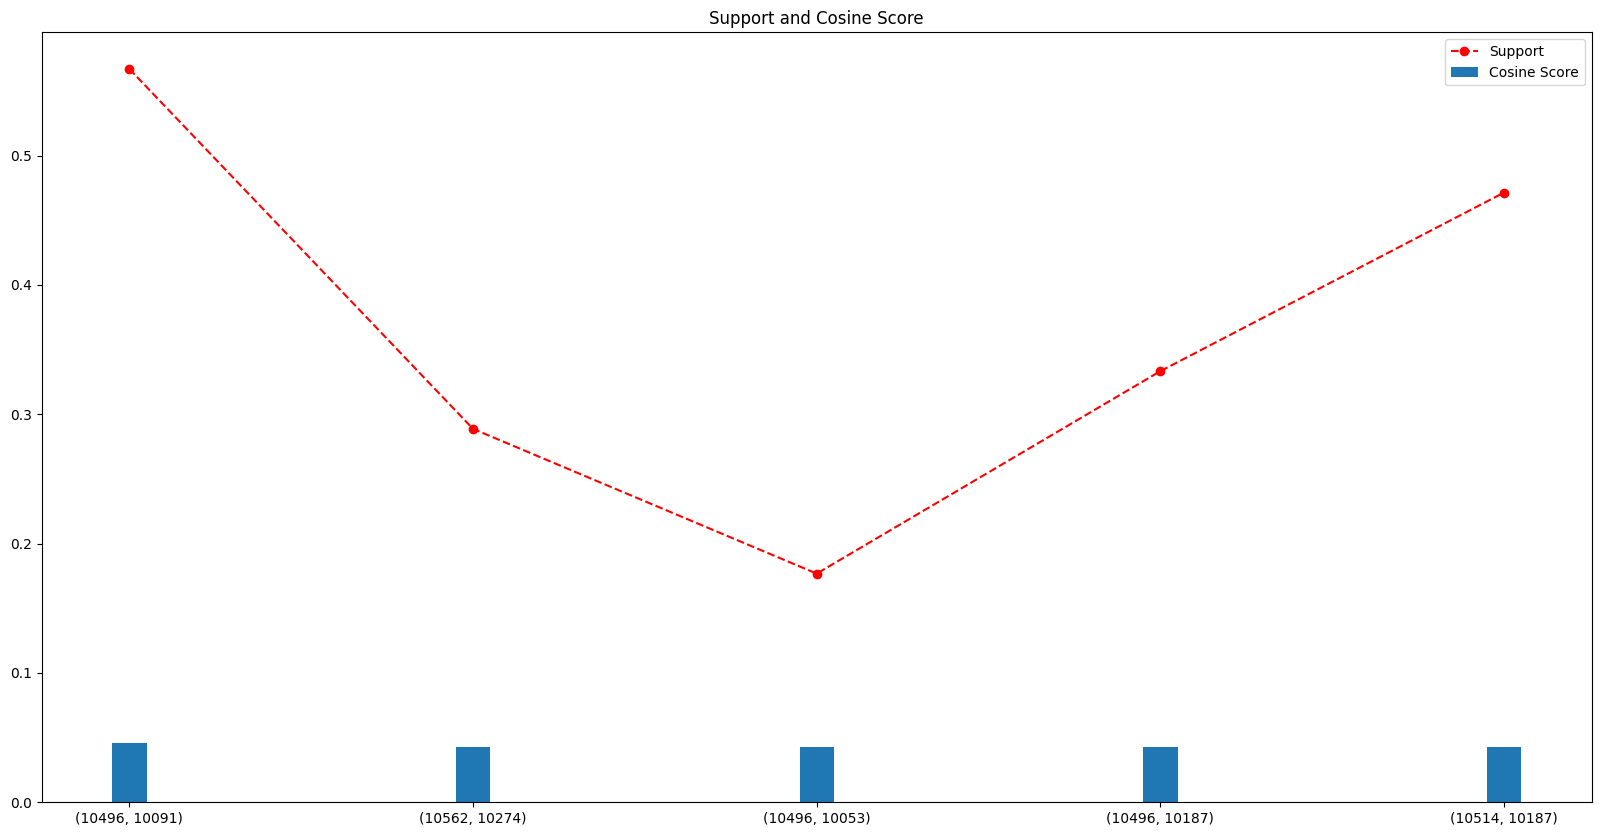

In [157]:
frequent_itemsets = [tuple(x) for x in immediate_rules['itemsets'].to_list()]
# support와 cosine score를 bar chart로 그리기

plt.figure(figsize=(20, 10))

#plt.bar([str(x) for x in range(len(supports))], supports)
#plt.bar([str(x) for x in range(len(cosine_scores))], cosine_scores)
# 두 개의 bar chart를 한 번에 그리기
plt.bar([str(x) for x in frequent_itemsets[10:15]], supports[10:15], label='Cosine Score', width=0.1)
#plt.bar([str(x) for x in immediate_rules['support'].to_list()], cosine_scores, label='Cosine Score', width=0.5)
plt.plot([str(x) for x in frequent_itemsets[10:15]], cosine_scores[10:15], label='Support', marker='o', linestyle='--', color='r')

plt.legend()

plt.title('Support and Cosine Score')


plt.show()

In [96]:
cocktail_profiles = pd.read_json(os.path.join(dataPath, 'merged_cocktail_list_new.json'), orient='records')
cocktail_profiles = cocktail_profiles[['ID', 'Ingredients']]
cocktail_profiles_dict = cocktail_profiles.set_index('ID').T.to_dict('list')

for key, value in cocktail_profiles_dict.items():
    ings = cocktail_profiles_dict[key][0]
    ings = [list(ing.split(' '))[2] for ing in ings]
    cocktail_profiles_dict[key] = ings


# 무작위로 두 칵테일 추출하기
for i in range(10):
    cocktail1 = random.choice(cocktail_profiles['ID'])
    cocktail2 = random.choice(cocktail_profiles['ID'])
    print(cocktail1, cocktail2)

    # cocktail1과 cocktail2의 Pearson Correlation 계산
    total_ings = set(cocktail_profiles_dict[cocktail1] + cocktail_profiles_dict[cocktail2])
    cocktail1_ings = set(cocktail_profiles_dict[cocktail1])
    cocktail2_ings = set(cocktail_profiles_dict[cocktail2])
    common_ings = cocktail1_ings.intersection(cocktail2_ings)
    pc_score = len(common_ings) / len(total_ings)
    print(pc_score)

    # cocktail1과 cocktail2의 Jaccard Similarity 계산
    js_score = len(common_ings) / (len(cocktail1_ings) + len(cocktail2_ings) - len(common_ings))
    print(js_score)

    # cocktail1과 cocktail2의 Cosine Similarity 계산
    cs_score = len(common_ings) / (len(cocktail1_ings) * len(cocktail2_ings)) ** 0.5
    print(cs_score)

    print()

10535 10515
0.2857142857142857
0.2857142857142857
0.4472135954999579

10196 10599
0.0
0.0
0.0

10409 10274
0.16666666666666666
0.16666666666666666
0.2886751345948129

10788 10583
0.0
0.0
0.0

10412 10488
0.3333333333333333
0.3333333333333333
0.5303300858899106

10053 10788
0.0
0.0
0.0

10187 10274
0.2
0.2
0.3849001794597505

10275 10303
0.4
0.4
0.5773502691896258

10053 10411
0.2222222222222222
0.2222222222222222
0.4082482904638631

10103 10107
0.14285714285714285
0.14285714285714285
0.2581988897471611



In [9]:
from util import get_dataframe
import json

In [26]:
dataPath = os.path.join('.', '..', '..', 'Dataset')
fname = os.path.join(dataPath, 'PRADA_cocktail_list.json')
df = get_dataframe(fname)


In [27]:
df.head()

,ID,Name,AverageRating,Ingredients,Description,Keywords,Volume,ABV
0,0,Alexander,4.5,"[30 ml whipped cream, 30 ml creme de cacao, 30...",This cocktail alexander recipe makes it all ni...,"[Cocktail Recipes, Creamy, Brandy & Cognac]",70,11.428571
1,1,Amaretto Sour,4.5,"[50 ml amaretto, 90 ml sweat and sour]","For a change of pace, an Amaretto Sour is just...","[Cocktail Recipes, Light Drink, Sour, Cocktail...",110,11.363636
2,2,Americano,4.3,"[30 ml sweet vermouth, 30 ml campari, 30 ml so...","A sweet cocktail is the Americano, which you c...","[Cocktail Recipes, Liqueurs, Bitter, Light Drink]",70,20.428571
3,3,Angel Blue-d,4.6,"[30 ml vodka, 30 ml blue curacao, 100 ml lemon...","With curaçao and vodka, the drink turns beauti...","[Cocktail Recipes, Vodka Cocktails, Spritzy, V...",160,12.187500
4,4,Aperol Lillet-d,3.7,"[5 pc ice, 10 ml aperol , 50 ml lillet, 100 ml...","The Aperol Lillet has only 3 ingredients, but ...","[Cocktail Recipes, Fresh, Fruity, Light Drink]",160,0.000000


In [7]:
print(
    df.describe(),
    df.info()
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             93 non-null     int64  
 1   Name           93 non-null     object 
 2   AverageRating  93 non-null     float64
 3   Ingredients    93 non-null     object 
 4   Description    93 non-null     object 
 5   Keywords       80 non-null     object 
 6   Volume         93 non-null     int64  
 7   ABV            93 non-null     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 5.9+ KB
              ID  AverageRating       Volume        ABV
count  93.000000      93.000000    93.000000  93.000000
mean   46.000000       4.490323   166.204301  20.755086
std    26.990739       0.232222   189.393400  12.578299
min     0.000000       3.400000    30.000000   0.000000
25%    23.000000       4.500000    70.000000  10.000000
50%    46.000000       4.500000   110.000000  20.000000
75% 

In [23]:
mapper = {}
test_list = []

ingredients = df['Ingredients'].to_list()
for ingredient_set in ingredients:
    
    for ingredient in ingredient_set:
        quantity, unit, name = ingredient.split(' ')[0], ingredient.split(' ')[1], ingredient.split(' ')[2:]
        quantity = quantity.strip()
        unit = unit.strip()
        name = ' '.join(name)
        name = name.strip()

        test_list.append((name, unit))
    
test_list = list(set(test_list))
test_list.sort()

print(len(test_list))
print(test_list)


104
[('Irish whiskey', 'ml'), ('absinthe', 'ml'), ('almond syrup', 'ml'), ('amaretto', 'ml'), ('aperol', 'ml'), ('apple', 'pc'), ('apple juice', 'ml'), ('apple liquer', 'ml'), ('apricot brandy', 'ml'), ('baileys', 'ml'), ('bitters', 'ml'), ('blue curacao', 'ml'), ('bourbon whiskey', 'ml'), ('brandy', 'ml'), ('cachaca', 'ml'), ('campari', 'ml'), ('champagne', 'ml'), ('cherry brandy', 'ml'), ('cider', 'ml'), ('cinnamon stick', 'pc'), ('cloves', 'pc'), ('cocktail(maraschino) cherry', 'pc'), ('coconut cream', 'ml'), ('coffee beans (decoration)', 'pc'), ('coke', 'ml'), ('cranberry juice', 'ml'), ('creme de cacao', 'ml'), ('creme de mint', 'ml'), ('cube sugar', 'pc'), ('currant liqueur', 'ml'), ('dark rum (heavy rum)', 'ml'), ('dry vermouth', 'ml'), ('espresso', 'ml'), ('gin', 'ml'), ('ginger ale', 'ml'), ('ginger beer', 'ml'), ('gold rum (medium rum)', 'ml'), ('grapefruit juice', 'ml'), ('grenadine syrup', 'ml'), ('high-proof rum', 'ml'), ('honey', 'ml'), ('ice', 'cup'), ('ice', 'l'), ('ice